# Latent Dirichlet allocation (LDA)

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [2]:
#import data
comments = pd.read_csv('../data/comments.csv')[['comments']].dropna().drop_duplicates()
len(comments['comments'])

4236

In [3]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                               'good','great', 'nice',
                               'ride','route','road','rt','roads', 'rode','way'
                              })

## Text Processing

In [19]:
ngram_range = (2, 4)

vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = comments.comments.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [20]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 482869


In [21]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [34]:
#LDA model parameters
num_topics = 3
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.005*"beautiful scenery" + 0.004*"little traffic" + 0.003*"elevation '
  'changes" + 0.003*"tail dragon" + 0.003*"speed limit" + 0.003*"twists turns" '
  '+ 0.003*"places stop" + 0.003*"highly recommend" + 0.002*"ridden times" + '
  '0.002*"lots curves"'),
 (1,
  '0.002*"speed limit" + 0.002*"blue ridge" + 0.002*"ridge parkway" + '
  '0.002*"blue ridge parkway" + 0.001*"state park" + 0.001*"highly recommend" '
  '+ 0.001*"starved rock" + 0.001*"don forget" + 0.001*"speed limit 45" + '
  '0.001*"limit 45"'),
 (2,
  '0.001*"west virginia" + 0.001*"triple nickel" + 0.001*"june 2020" + '
  '0.001*"state park" + 0.001*"140 miles" + 0.001*"ranger july" + 0.001*"sioux '
  'city" + 0.001*"watch rocks" + 0.001*"500 miles" + 0.001*"marietta oh"')]


In [35]:
# get_document_topics method shows the topics found 
# in each corpus doc
# i = 0
# print(comments.iloc[i], processed_text[i], lda_model.get_document_topics(corpus[i]))

In [36]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [37]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [38]:
# len(main_topic_df)

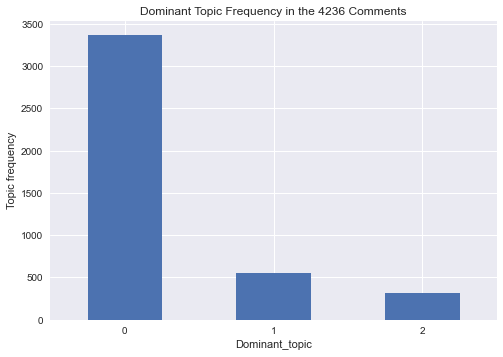

In [39]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(comments)} Comments',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [40]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 2356  
        Dominant topic: 0
 
    
Hiway 276 from the NC-SC state line has been totally repaved from Ceasar's Head down into Brevard, NC fall 2008. Super smooth but still twisty so watch your speed as you will want to ride faster than the road will allow.,This road is fun!  I've been riding it for years and has always provided a thrill and gorgeous scenery.  The SC side is not in good shape anymore and will suprise you with some loose spots if you aren't careful. Once you reach the summit the NC side is new and very smooth and confidence inspiring.  Overall a great riding experience for the sportbike and cruiser/touring motorcyclist alike!,As of 9/26/2020, there are two articles related to Caesar's Head.  One takes you from Brevard ("Caesar's Ascent") and the other from Hwy 11 ("Caesar's Head").  Going to attempt a cross post in both. 

Rode Hwy 276 on 9/19/20 from Cherokee Foothills Scenic Hwy 11 to Brevard, NC.  Video is not excellent, but will give you some i

## Length of documents in each topic

In [41]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [42]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=2), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

<AxesSubplot:title={'center':'Top Word Frequencies in 4236 MR.com Comments'}, ylabel='Word frequency'>

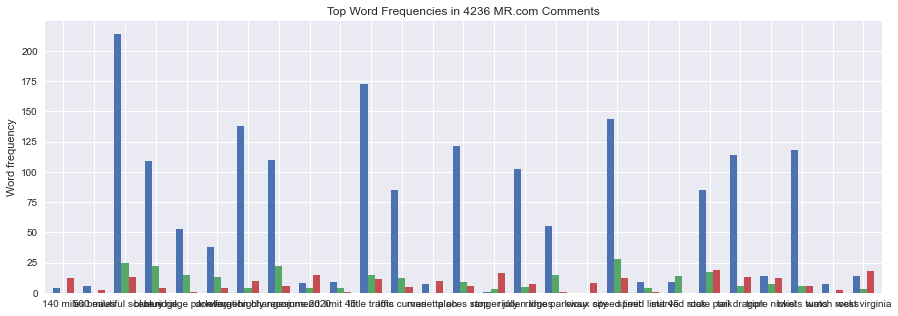

In [43]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

#print('Indices of top words: \n{}\n'.format(lda_top_words_index))
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']
(
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7,
              ylabel='Word frequency',
              legend=False,
              title=f'Top Word Frequencies in {len(texts)} MR.com Comments',
              rot=0
             )
)
# .set(ylabel='Word frequency', 
#          title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')

## Coherence scores based on number of topics

In [32]:
coherence_scores = []

for n in range(1, 5):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

Coherence scores for the ngram range: (2, 4) 
 [(1, 0.21388447564185165), (2, 0.38032784157360167), (3, 0.4321074886161722), (4, 0.4048274982653719)]


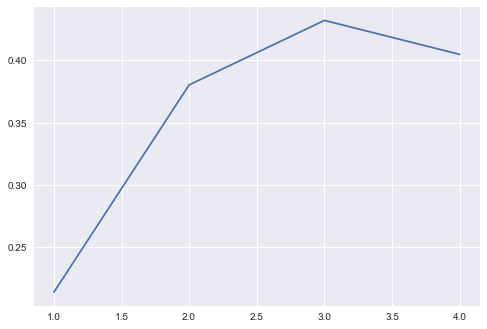

In [33]:
print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
plt.plot(topic_range,cscore)

# Conclusions

- There seem to be 3-4 groups of users making comments on this website.
- IF 3:
    0. The 'core' group of users make most of the comments.
    1. The second group are those who are not as frequent commenters, but when they do post, they usually share videos/links to other sites.
    2. The last group do not frequently comment or share videos/links.
- IF 4:
    0. The 'core' group of users make most of the comments.
    1. Post like core group, but less overall. Maybe newer members/budding 'core' group?
    2. People riding the tail of the dragon.
    3. Other infrequent posters.